In [1]:
# Tensorly library
import tensorly as tl
from tensorly.metrics import regression
import numpy as np
from functools import reduce
import time
import torch

In [15]:
"""
TENSOR TO TENSOR REGRESSION v1    
  Inputs:
    X - Input Tensor, shape (N, I_1, ..., I_{M1})
    Y - Output Tensor, shape (N, J_1, ..., J_{M2})
    rank - The rank of the solution weights matrix
    lambda_reg - how much l2 regularization to use
    return_factors - whether to include the weight matrix factors along with the weight matrix itself
    eps - the precision of our estimate
    normalize - boolean which determines whether to normalize the factors at every step
    anneal_steps - How many steps to use when annealing the lambda_parameter
    max_steps - the maximum number of steps to iterate for when searching for a solution
    
  Outputs:
    W - weight matrix tensor, shape (I_1, ..., I_{M1}, J_1, ..., J_{M2})
    factors - List of CP factors which forms the CP decomposition of W. Will only be returned if return_factors==True
"""
def tensor_to_tensor_regression_2(X, Y, rank, lambda_fin=0.0, 
                                              return_factors=False, 
                                              eps=1e-4,
                                              normalize=True,
                                              anneal_steps=0, 
                                              max_steps=1000):
    
    # Check that the N is consistent between X and Y tensors
    if X.shape[0] != Y.shape[0]:
        print("Wrong leading dimensions for tensors X and Y")
    
    # Number of examples (leading dimension in the tensor)
    N = X.shape[0]
    M1 = tl.ndim(X) - 1 # Exclude the first mode corresponding to N (no. samples)
    M2 = tl.ndim(Y) - 1
    
    I = reduce(lambda x, y: x * y, X.shape[1:])
    J = reduce(lambda x, y: x * y, Y.shape[1:])
    
    np.random.seed(123)
    # Initialize the u_r and v_r vectors which we will directly optimize
    Us = [tl.tensor(np.random.random((X.shape[m1 + 1], rank))-0.5) for m1 in range(M1)]
    Vs = [tl.tensor(np.random.random((Y.shape[m2 + 1], rank))-0.5) for m2 in range(M2)]
    
    # Y vector 
    Y_vec = tl.tensor_to_vec(Y)
    
    steps = 0
    prev_error = -1
    
    while steps < max_steps:
        # Anneal the lambda_parameter to convexify the objective
        if steps < anneal_steps:
            lambda_reg = lambda_fin + 100 * (anneal_steps - steps) / anneal_steps
        else:
            lambda_reg = lambda_fin
        # Optimizing U_m1 
        for m1 in range(M1):
            C_r_mats = []
            for r in range(rank):
                # Columns we will kronecker together
                cols_to_kron = []
                for m1_p in range(M1):
                    if m1_p != m1:
                        # r-th column of U_m1
                        cols_to_kron.append(Us[m1_p][:,r])
                for m2_p in range(M2):
                    cols_to_kron.append(Vs[m2_p][:,r])
                contractor_shape = tuple(x for i, x in enumerate(X.shape[1:]) if i != m1) + Y.shape[1:]
                contractor = tl.vec_to_tensor(tl.tenalg.kronecker(cols_to_kron), contractor_shape)
                X_modes = [i for i in range(1, M1 + 1) if i != m1 + 1]
                # Create the C_r tensor
                C_r = tl.tenalg.contract(X, X_modes, contractor, range(M1 - 1)) 
                # Append to the list, unfolding as we go
                C_r_mats.append(tl.transpose(tl.unfold(C_r, 1)))
            # Concat along the dimension we unfolded to generate the C matrix
            C_mat = tl.stack(C_r_mats, axis=-1).reshape(N * J, rank * X.shape[m1 + 1])
            
            # Here we compute the regularization component of V
            B_r = []
            for r in range(rank):
                to_kron = []
                for m1_p in range(M1):
                    if m1_p != m1:
                        to_kron.append(Us[m1_p][:,r])
                for m2_p in range(M2):
                    to_kron.append(Vs[m2_p][:,r])
                B_r.append(tl.tenalg.kronecker(to_kron))
            B = tl.stack(B_r, axis=-1)
            reg_mat = lambda_reg * tl.tenalg.kronecker([tl.transpose(B) @ B, tl.eye(X.shape[m1 + 1])])
            U_m1_vec = tl.solve(tl.transpose(C_mat) @ C_mat + reg_mat, tl.transpose(C_mat) @ Y_vec)
            # Finally update the U_m1 matrix
            Us[m1] = tl.vec_to_tensor(U_m1_vec, Us[m1].shape)
                
        # Optimizing all the Vs    
        for m2 in range(M2):
            d_r_vecs = []
            for r in range(rank):
                # Columns we will kronecker together
                cols_to_kron = []
                for m1_p in range(M1):
                    # r-th column of U_m1
                    cols_to_kron.append(Us[m1_p][:,r])
                for m2_p in range(M2):
                    if m2 != m2_p:
                        cols_to_kron.append(Vs[m2_p][:,r])
                contractor_shape = X.shape[1:] + tuple(y for i, y in enumerate(Y.shape[1:]) if i != m2)
                contractor = tl.tenalg.kronecker(cols_to_kron).reshape(contractor_shape)
                # Create the C_r tensor
                d_r = tl.tensor_to_vec(tl.tenalg.contract(X, range(1, M1 + 1), contractor, range(M1)))
                d_r_vecs.append(d_r.reshape((d_r.shape[0], 1)))
            D_mat = tl.concatenate(d_r_vecs, axis=1)
            # Compute the regularization component
            B_r = []
            for r in range(rank):
                to_kron = []
                for m1_p in range(M1):
                    to_kron.append(Us[m1_p][:,r])
                for m2_p in range(M2):
                    if m2_p != m2:
                        to_kron.append(Vs[m2_p][:,r])
                B_r.append(tl.tenalg.kronecker(to_kron))
            B = tl.stack(B_r, axis=-1)
            reg_mat = lambda_reg * tl.transpose(B) @ B
            # Get the correct Y_m2 matrix
            Y_m2 = tl.unfold(Y, m2 + 1)
            
            # Do the final update
            Vs[m2] = tl.transpose(tl.solve(tl.transpose(D_mat) @ D_mat + reg_mat, tl.transpose(Y_m2 @ D_mat)))

        # Compute error here
        # Construct W
        if steps >= 5:
            weight_shape = X.shape[1:] + Y.shape[1:]
            W = tl.zeros(weight_shape)
            for r in range(rank):
                to_kron = []
                for m1 in range(M1):
                    to_kron.append(Us[m1][:,r])
                for m2 in range(M2):
                    to_kron.append(Vs[m2][:,r])
                W += tl.vec_to_tensor(tl.tenalg.kronecker(to_kron), weight_shape)
            Y_pred = tl.tenalg.contract(X, range(1, M1 + 1), W, range(M1))
            error_no_reg = regression.MSE(Y_pred, Y)
            error = error_no_reg + lambda_reg * tl.norm(W)
        
            # Determine if we have converged
            if prev_error >= 0 and abs(prev_error - error) < eps:
                print("Converged after", steps, "steps. Final Error:", error, "No Reg:", error_no_reg)
                break
            else:
                # pass
                print("Step:", steps, "Error w/ reg:", round(error, 6), "Error w/o reg:", round(error_no_reg, 6))
            # Reset the previous error
            prev_error = error
        # Next step
        steps += 1
        
#       Normalization Step
        if normalize:
            for r in range(rank):
                tot_norm = 1
                for m1 in range(M1):
                    nrm = tl.norm(Us[m1][:,r], 2)
                    tot_norm *= nrm
                    Us[m1][:,r] /= nrm
                for m2 in range(M2):
                    nrm = tl.norm(Vs[m2][:,r], 2)
                    tot_norm *= nrm
                    Vs[m2][:,r] /= nrm
                tot_norm = tot_norm ** (1 / (M1 + M2))
                for m1 in range(M1):
                    Us[m1][:,r] *= tot_norm
                for m2 in range(M2):
                    Vs[m2][:,r] *= tot_norm
    
    if return_factors:
        return W, Us, Vs # Return the factors along with the W tensor
    else:
        return W

In [16]:
N = 11
np.random.seed(13)
tl.set_backend('numpy')
X = tl.tensor(np.random.random((N, 5, 7)) * 1)
Y = tl.tensor(np.zeros((N, 2, 3)))
# Setup Y tensor with some dummy data
for n in range(N):
    x = X[n]
    Y[n] = tl.tensor(np.array([[x[0, 0] + x[1, 1] , 2 * x[1, 0] - x[3, 2], (x[4, 5] + 1) ** 2],
                    [-x[1, 6] + 3 * x[1, 5] ,  - x[0, 6] - x[3, 3], (x[2, 5] + 2) ** 2]]))
# Now fit it
start_time = time.time()
W = tensor_to_tensor_regression_2(X, Y, 5, lambda_fin=0.1)
print("Calculation took", time.time() - start_time, "seconds")

# How to predict with the W tensor
Y_pred = tl.tenalg.contract(X, range(1, tl.ndim(X)), W, range(tl.ndim(X) - 1))

Step: 5 Error w/ reg: 0.620154 Error w/o reg: 0.0854
Step: 6 Error w/ reg: 0.619959 Error w/o reg: 0.079909
Step: 7 Error w/ reg: 0.619056 Error w/o reg: 0.074238
Step: 8 Error w/ reg: 0.617185 Error w/o reg: 0.068166
Step: 9 Error w/ reg: 0.615804 Error w/o reg: 0.062213
Step: 10 Error w/ reg: 0.615179 Error w/o reg: 0.05837
Step: 11 Error w/ reg: 0.616492 Error w/o reg: 0.055056
Step: 12 Error w/ reg: 0.624244 Error w/o reg: 0.051037
Step: 13 Error w/ reg: 0.633436 Error w/o reg: 0.047658
Step: 14 Error w/ reg: 0.641525 Error w/o reg: 0.044913
Step: 15 Error w/ reg: 0.64757 Error w/o reg: 0.042485
Step: 16 Error w/ reg: 0.651193 Error w/o reg: 0.040197
Step: 17 Error w/ reg: 0.652675 Error w/o reg: 0.038093
Step: 18 Error w/ reg: 0.652562 Error w/o reg: 0.036329
Step: 19 Error w/ reg: 0.651365 Error w/o reg: 0.035013
Step: 20 Error w/ reg: 0.649572 Error w/o reg: 0.034143
Step: 21 Error w/ reg: 0.647608 Error w/o reg: 0.03364
Step: 22 Error w/ reg: 0.645769 Error w/o reg: 0.033401
St

In [18]:
# Here we do a proof of concept by doing a face completion task on the CelebA dataset.
import torchvision
from torchvision import transforms
import torch

transform = transforms.Compose([
    #transforms.Scale(64),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Load the test set so it goes faster 
train_set = torchvision.datasets.CelebA("", split='test', transform=transform, download=False)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set))
train_set_array = next(iter(train_loader))[0].numpy()

# Use the validation set again for efficiency's sake
test_set = torchvision.datasets.CelebA("", split='valid', transform=transform, download=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set))
test_set_array = next(iter(test_loader))[0].numpy()

In [19]:
# Reshape to allow for easy plotting
train_set_array_reshaped = train_set_array.transpose((0, 2, 3, 1))
test_set_array_reshaped = test_set_array.transpose((0, 2, 3, 1))

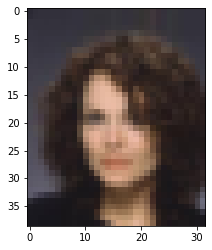

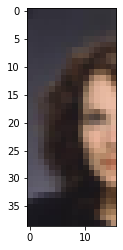

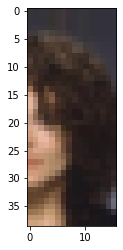

In [27]:
import matplotlib.pyplot as plt

# Show the full image (note that we have to scale between 0 and 1 to imshow properly)
full = (test_set_array_reshaped[0] + 1) / 2
plt.figure()
plt.imshow(full)

# Now plot just half the left half face
left = (test_set_array_reshaped[0][:,:16,:] + 1) / 2
plt.figure()
plt.imshow(left)

# Now the right half
right = (test_set_array_reshaped[0][:,16:,:] + 1) / 2
plt.figure()
plt.imshow(right)

In [31]:
train_N = 10
# Input tensor will be the left side of the face
celebA_X = train_set_array_reshaped[:train_N,:,:16,:]
# Output tensor will be the right side of the face
celebA_Y = train_set_array_reshaped[:train_N,:,16:,:]

In [37]:
# Execute the training of the weights
start_time = time.time()
celebA_W = tensor_to_tensor_regression_2(celebA_X, celebA_Y, 12, lambda_fin=0.01, eps=1e-3, anneal_steps=0, max_steps=10000)
print("Calculation took", time.time() - start_time, "seconds")

Step: 5 Error w/ reg: 1.109026 Error w/o reg: 0.037199
Step: 6 Error w/ reg: 1.129849 Error w/o reg: 0.035995
Step: 7 Error w/ reg: 1.164456 Error w/o reg: 0.035302
Step: 8 Error w/ reg: 1.165826 Error w/o reg: 0.034765
Step: 9 Error w/ reg: 1.137756 Error w/o reg: 0.034254
Step: 10 Error w/ reg: 1.091761 Error w/o reg: 0.033705
Step: 11 Error w/ reg: 1.028802 Error w/o reg: 0.033148
Step: 12 Error w/ reg: 0.960364 Error w/o reg: 0.032664
Step: 13 Error w/ reg: 0.895932 Error w/o reg: 0.032273
Step: 14 Error w/ reg: 0.834283 Error w/o reg: 0.031957
Step: 15 Error w/ reg: 0.777889 Error w/o reg: 0.031696
Step: 16 Error w/ reg: 0.743977 Error w/o reg: 0.031484
Step: 17 Error w/ reg: 0.71763 Error w/o reg: 0.031306
Step: 18 Error w/ reg: 0.696251 Error w/o reg: 0.031152
Step: 19 Error w/ reg: 0.678003 Error w/o reg: 0.031016
Step: 20 Error w/ reg: 0.662621 Error w/o reg: 0.030891
Step: 21 Error w/ reg: 0.649706 Error w/o reg: 0.030775
Step: 22 Error w/ reg: 0.63886 Error w/o reg: 0.030664

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 39, 16, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


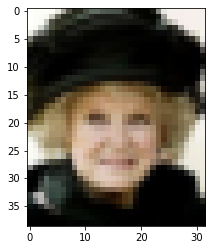

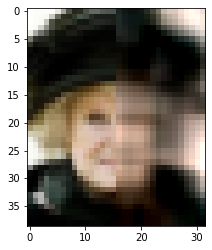

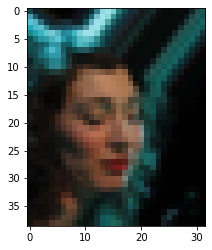

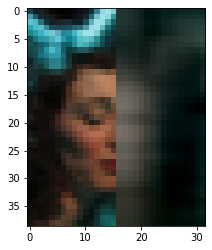

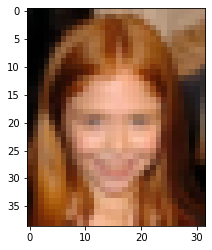

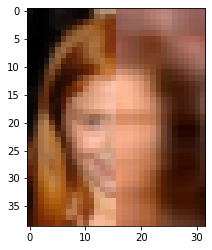

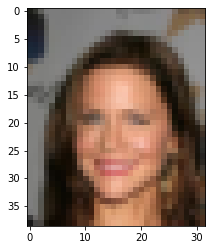

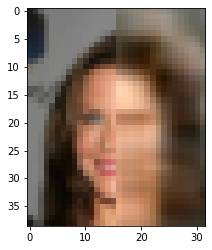

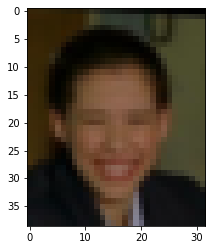

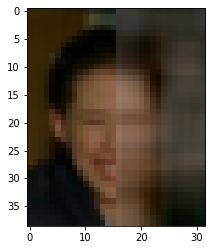

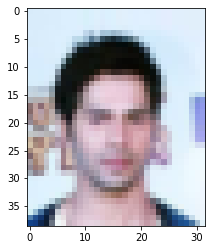

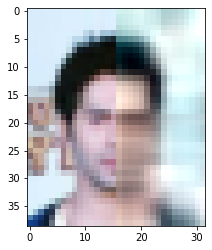

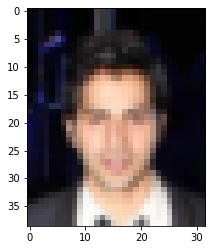

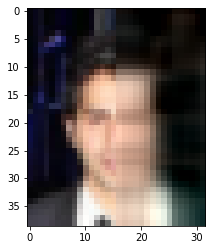

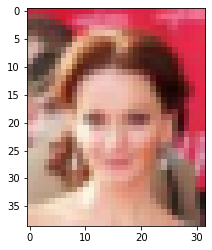

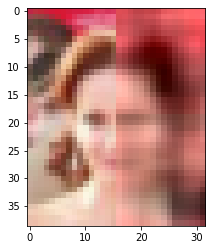

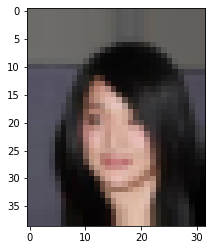

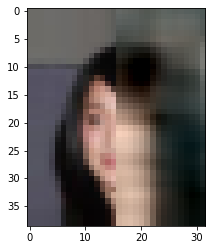

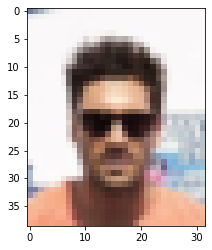

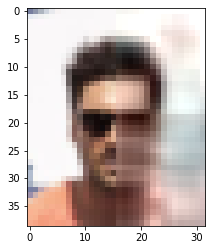

In [38]:
# How did we do in sample? Lets take a look
celebA_Ypred = tl.tenalg.contract(celebA_X, range(1, tl.ndim(celebA_X)), celebA_W, range(tl.ndim(celebA_X) - 1))
print(celebA_Ypred.shape)
for n in range(train_N):
    full = train_set_array_reshaped[n]
    reconstr = tl.concatenate((celebA_X[n], celebA_Ypred[n]), axis=1)
    plt.figure()
    plt.imshow((full + 1) / 2)
    plt.figure()
    plt.imshow((reconstr + 1) / 2)

In [39]:
# How did we do out of sample? Probably very bad considering we only trained on 10 points

(10, 39, 16, 3)